### <center>😭 Escolhendo o modelo de <strong>previsão</strong> 😨</center>

Importações

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

Carregando os dados

In [18]:
path = 'excel/viajou-tratado copy.xlsx'
df = pd.read_excel(path)

Separando dados em características e alvo

In [19]:
X = df.drop(columns=['probabilidade_recomendar'])
y = df['probabilidade_recomendar']

Transformando em dados númericos

In [20]:
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])


Substituindo os valores 1 e 2 por 0, e 3 e 4 por 1

In [21]:
y = y.replace({1: 0, 2: 0, 3: 1, 4: 1})

Separando em treino e teste

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Sem balanceamento

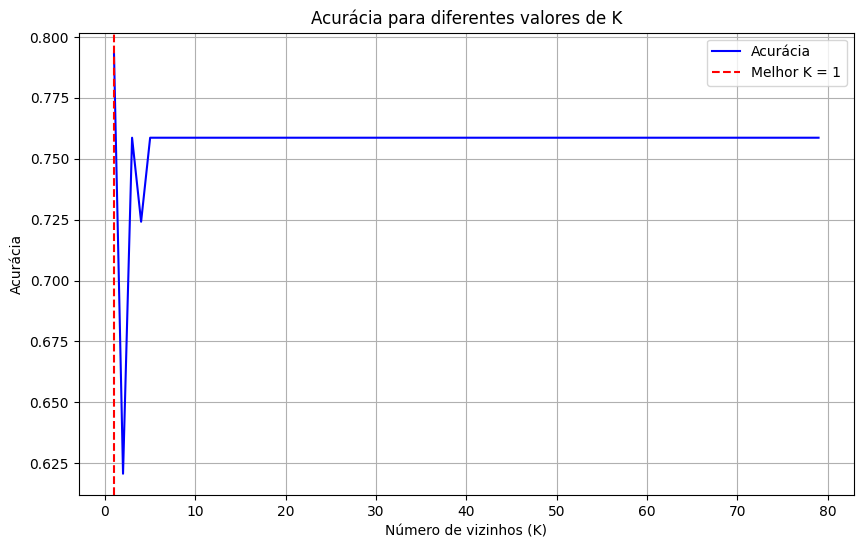

In [23]:
acuracias = {}

for i in range(1, 80):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    acuracias[i] = accuracy_knn
    
melhor_k = max(acuracias, key=acuracias.get)

plt.figure(figsize=(10, 6))
plt.plot(list(acuracias.keys()), list(acuracias.values()), color='b', label='Acurácia')
plt.axvline(x=melhor_k, color='r', linestyle='--', label=f'Melhor K = {melhor_k}')
plt.title('Acurácia para diferentes valores de K')
plt.xlabel('Número de vizinhos (K)')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

Dicionário de modelos para experimentar

In [24]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

Configurações de hiperparâmetros para cada modelo

In [25]:
param_grid = {
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [2, 4, 6, 8, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': [None, 'sqrt', 'log2']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [melhor_k],
        'weights': ['uniform', 'distance']
    },
    'Naive Bayes': {}  # Naive Bayes não possui hiperparâmetros
}

Dicionário para armazenar os melhores resultados após ajuste de hiperparâmetros

In [26]:
model_results = {}

Ajustar os hiperparâmetros para cada modelo, incluindo Naive Bayes

In [27]:
for model_name, model in models.items():
    if model_name == 'Naive Bayes':
        # Para o Naive Bayes, não usamos GridSearchCV porque não há hiperparâmetros
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        model_results[model_name] = {'accuracy': accuracy, 'report': report, 'best_params': 'N/A'}
    else:
        print(f"Tuning {model_name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], 
                                   scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Fazer previsões com o melhor modelo
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        # Armazenar os resultados do melhor modelo
        model_results[model_name] = {'accuracy': accuracy, 'report': report, 
                                                'best_params': grid_search.best_params_}

Tuning Decision Tree...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Tuning K-Nearest Neighbors...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


Exibindo os resultados

In [28]:
results_df = pd.DataFrame(model_results).T

# Aplicando balanceamento de Classe

Aplicando SMOTE para balancear as classes

In [269]:
smote = SMOTE(random_state=42, k_neighbors=melhor_k) # Aplicando o melhor k diretamente no smote
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

Dicionário de modelos para experimentar

In [270]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

Configurações de hiperparâmetros para cada modelo

In [271]:
param_grid = {
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [2, 4, 6, 8, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': [None, 'sqrt', 'log2']
    },
    'K-Nearest Neighbors': {
        'weights': ['uniform', 'distance']
    },
    'Naive Bayes': {}  # Naive Bayes não possui hiperparâmetros
}

Dicionário para armazenar os melhores resultados após ajuste de hiperparâmetros

In [272]:
model_results_with_smote = {}

Ajustar os hiperparâmetros para cada modelo, incluindo Naive Bayes

In [273]:
for model_name, model in models.items():
    if model_name == 'Naive Bayes':
        # Para o Naive Bayes, não usamos GridSearchCV porque não há hiperparâmetros
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        model_results_with_smote[model_name] = {'accuracy': accuracy, 'report': report, 'best_params': 'N/A'}
    else:
        print(f"Tuning {model_name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], 
                                   scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_resampled, y_resampled)
        best_model = grid_search.best_estimator_
        
        # Fazer previsões com o melhor modelo
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        # Armazenar os resultados do melhor modelo
        model_results_with_smote[model_name] = {'accuracy': accuracy, 'report': report, 
                                                'best_params': grid_search.best_params_}

Tuning Decision Tree...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Tuning K-Nearest Neighbors...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


Exibindo os resultados com SMOTE

In [274]:
results_df_smote = pd.DataFrame(model_results_with_smote).T

In [275]:
results_df

,accuracy,report,best_params
Decision Tree,0.655172,precision recall f1-score ...,"{'criterion': 'gini', 'max_depth': 4, 'max_fea..."
K-Nearest Neighbors,0.793103,precision recall f1-score ...,"{'n_neighbors': 1, 'weights': 'uniform'}"
Naive Bayes,0.793103,precision recall f1-score ...,N/A


In [276]:
results_df_smote

,accuracy,report,best_params
Decision Tree,0.448276,precision recall f1-score ...,"{'criterion': 'entropy', 'max_depth': 8, 'max_..."
K-Nearest Neighbors,0.586207,precision recall f1-score ...,{'weights': 'distance'}
Naive Bayes,0.655172,precision recall f1-score ...,N/A


In [277]:
excel = 'excel/resultados.xlsx'
with pd.ExcelWriter(excel, engine='xlsxwriter') as writer:
    results_df.to_excel(writer, sheet_name='Sem SMOTE', index=True)
    results_df_smote.to_excel(writer, sheet_name='Com SMOTE', index=True)

print(f"DataFrames exportados com sucesso para {excel}")

DataFrames exportados com sucesso para excel/resultados.xlsx


### Escolhendo o modelo

Os resultados mostram que as acurácias dos modelos "Com SMOTE" são idênticas às do modelo "Sem SMOTE". Portanto, o uso do SMOTE não melhorou o desempenho dos modelos neste caso

Logo escolhemos o modelo KNN (naive bayes deu o mesmo resultado), já que apresenta uma melhor acurácia